# Pylops - Convolve

### Author: M.Ravasi

This notebook showcases the use of `pylops.signalprocessing.Convolve1D` for two scenarios:
    
    - filter h is smaller than input signal
    - filter h is larger than input signal

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from scipy.signal import convolve, correlate, fftconvolve, oaconvolve
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing           import *

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

## Compare with old convmtx

In [35]:
from pylops.utils.backend import get_array_module, get_toeplitz

def convmtxOLD(h, n):
    ncp = get_array_module(h)
    if len(h) < n:
        col_1 = ncp.r_[h[0], ncp.zeros(n - 1, dtype=h.dtype)]
        row_1 = ncp.r_[h, ncp.zeros(n - 1, dtype=h.dtype)]
    else:
        row_1 = ncp.r_[h[0], ncp.zeros(n - 1, dtype=h.dtype)]
        col_1 = ncp.r_[h, ncp.zeros(n - 1, dtype=h.dtype)]
    C = get_toeplitz(h)(col_1, row_1)
    return C

(33,)


((512, 544), (544, 512), (544, 512), True, True)

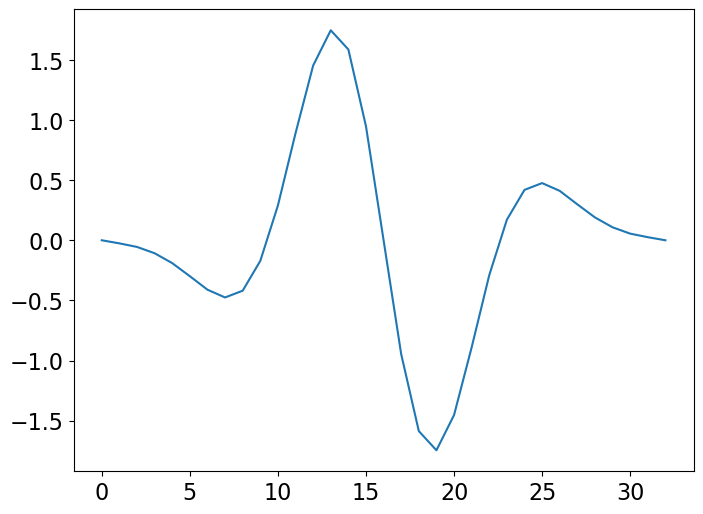

In [36]:
nh = 17
h, _, offset = ricker(np.arange(nh)*0.004, 15)
offset = offset+10
nh = len(h)
Fop = FirstDerivative(h.shape)
h = Fop @ h * 5
print(h.shape)

plt.plot(h)

n = 512

HOLD = convmtxOLD(np.flipud(h), n)
H = convmtx(h, n, nh//2)
H1 = sp.linalg.convolution_matrix(h, n)

HOLD.shape, H.shape, H1.shape, np.allclose(HOLD[:, nh//2:-nh//2+1], H1[nh//2:-nh//2+1]), np.allclose(H[:n], H1[nh//2:-nh//2+1])

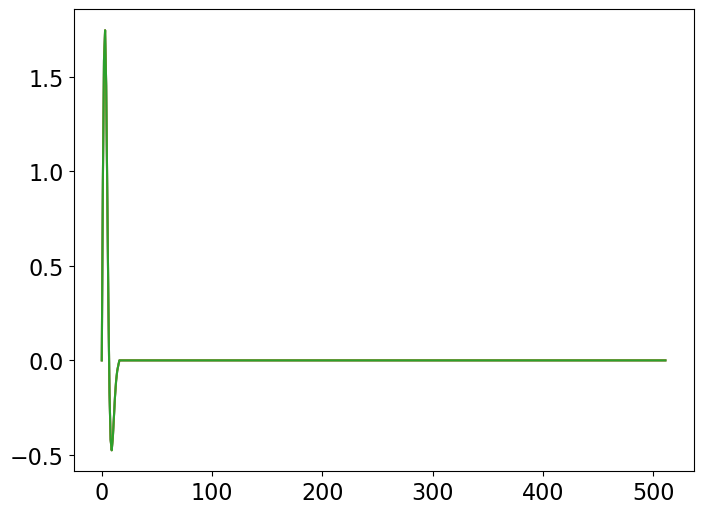

In [37]:
plt.plot(HOLD[0, nh//2:-nh//2+1])
plt.plot(H[0])
plt.plot(H1[nh//2:-nh//2+1][0]);

(33,)


((544, 33), (544, 33), (544, 33), True, True)

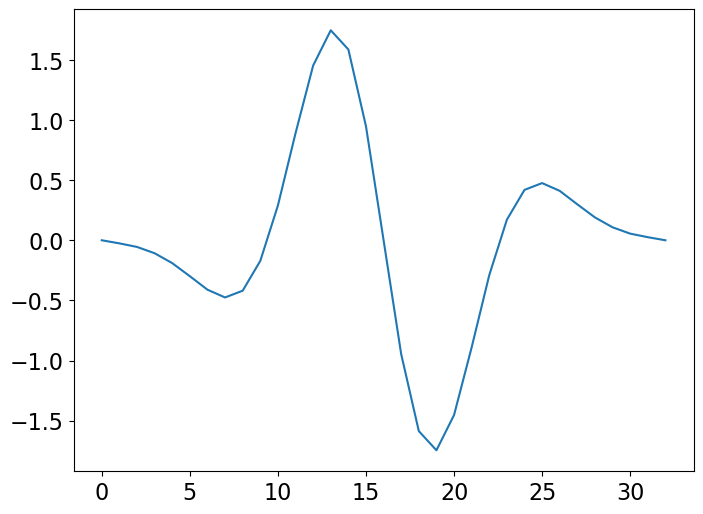

In [43]:
nh = 17
h, _, offset = ricker(np.arange(nh)*0.004, 15)
offset = offset+10
nh = len(h)
Fop = FirstDerivative(h.shape)
h = Fop @ h * 5
print(h.shape)

plt.plot(h)

x = np.zeros(n)
x[n//2] = 1

HOLD = convmtxOLD(np.flipud(x), len(h))
H = convmtx(x, len(h), nh//2)
H1 = sp.linalg.convolution_matrix(x, len(h))

HOLD.shape, H.shape, H1.shape, np.allclose(HOLD[nh//2:-nh//2+1], H1[nh//2+1:-nh//2+2]), np.allclose(H[:n], H1[nh//2:-nh//2+1])

## 1d Convolution

(72,)


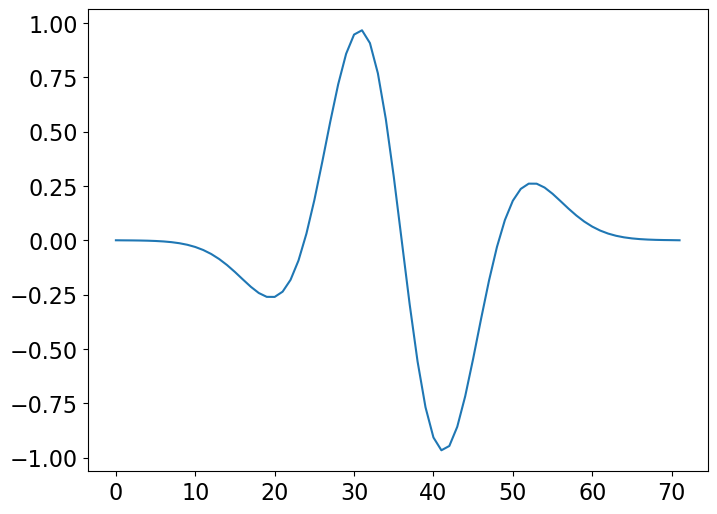

In [7]:
nx = 201
x  = np.zeros(nx)
x[120] = 1

nh = 38
h, _, offset = ricker(np.arange(nh)*0.004, 8)
h = h[:-1]
offset = offset+10
nh = len(h)
print(h.shape)

Fop = FirstDerivative(h.shape)
h = Fop @ h * 5

plt.figure()
plt.plot(h);

### Filter in operator

In [8]:
# Dense
H = convmtx(h, nx, offset)
H = H[:nx]
print(H.shape, x.shape)

# LinOp
Hop = Convolve1D(nx, h=h, offset=offset)
dottest(Hop, nx, nx, verb=True)

y = H @ x
yop = Hop @ x

xadj = H.T @ y
xadjop = Hop.H @ y

(201, 201) (201,)
Dot test passed, v^H(Opu)=43.13745494149021 - u^H(Op^Hv)=43.137454941490205


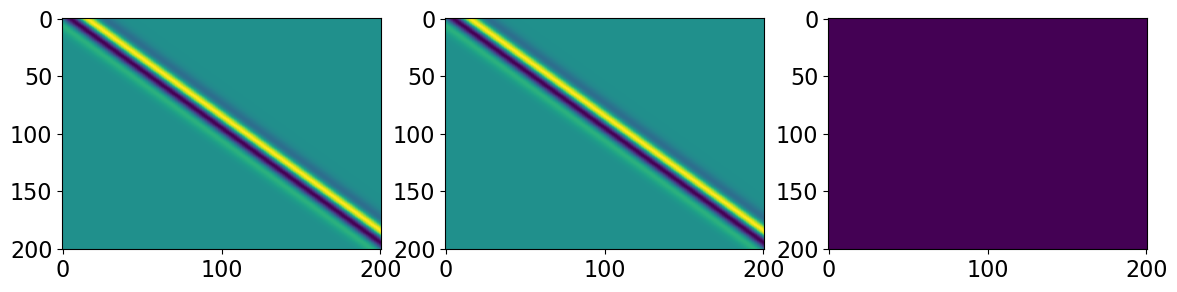

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))
axs[0].imshow(H)
axs[0].axis('tight')
axs[1].imshow(Hop.todense())
axs[1].axis('tight')
axs[2].imshow(H-Hop.todense())
axs[2].axis('tight');

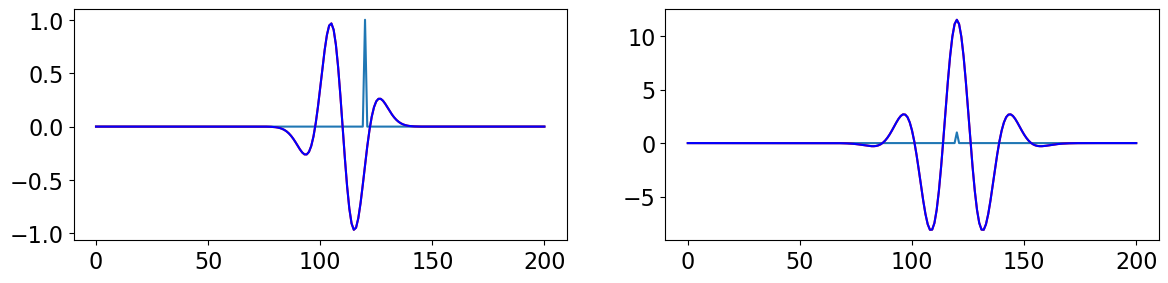

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 3))
axs[0].plot(x)
axs[0].plot(y, 'r')
axs[0].plot(yop, 'b')

axs[1].plot(x)
axs[1].plot(xadj, 'r')
axs[1].plot(xadjop, 'b')

assert np.allclose(y, yop)
assert np.allclose(xadj, xadjop)

### Signal in operator

First with matrix

In [11]:
Xop = Convolve1D(nh, h=x, offset=offset)
X = convmtx(x, nh, offset)[:nx]
Xop = Convolve1D(nh, h=x, offset=offset)
#dottest(Xop, verb=True)

y1 = X @ h
yop1 = Xop @ h

xadj1 = X.T @ y1
xadjop1 = Xop.H @ y1

True

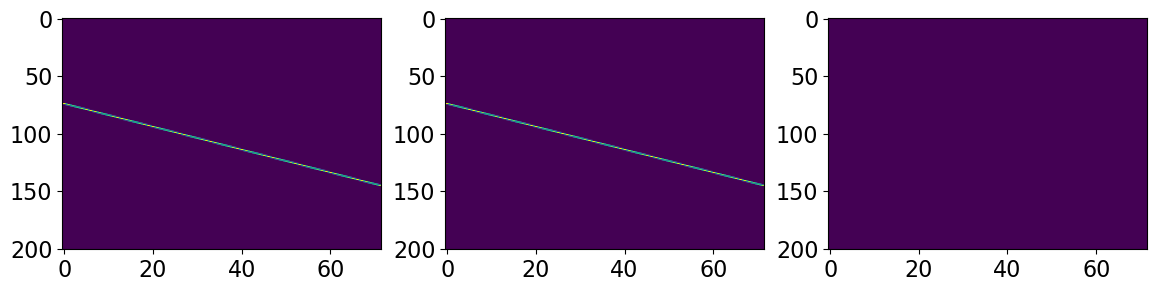

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))
axs[0].imshow(X)
axs[0].axis('tight')
axs[1].imshow(Xop.todense())
axs[1].axis('tight')
axs[2].imshow(X-Xop.todense())
axs[2].axis('tight');

np.allclose(X, Xop.todense())

True

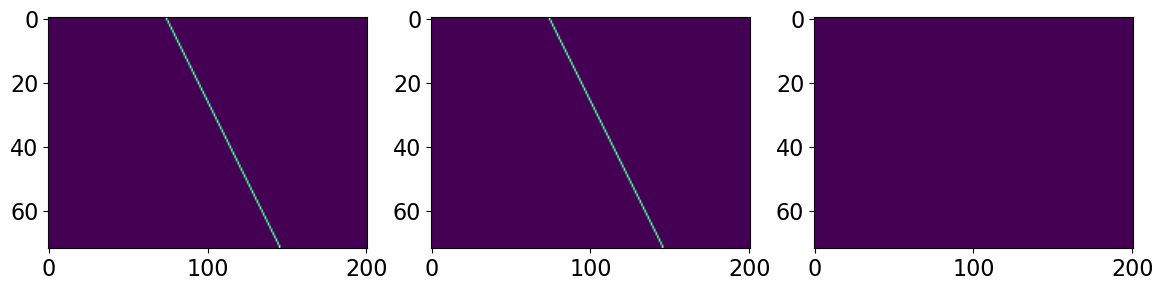

In [13]:
identity = np.eye(Xop.shape[0], dtype=Xop.dtype)
XopHdense = np.conj(Xop.rmatmat(identity)).T

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
axs[0].imshow(X.T)
axs[0].axis('tight')
axs[1].imshow(XopHdense.T)
axs[1].axis('tight')
axs[2].imshow(X.T-XopHdense.T)
axs[2].axis('tight');

np.allclose(X, XopHdense)

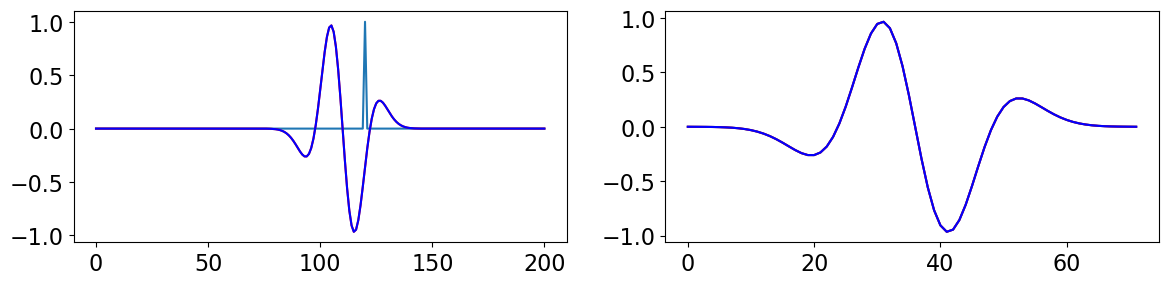

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14, 3))
axs[0].plot(x)
axs[0].plot(y1, 'r')
axs[0].plot(yop1, 'b')

axs[1].plot(h)
axs[1].plot(xadj1, 'r')
axs[1].plot(xadjop1, 'b')

assert np.allclose(y1, yop1)
assert np.allclose(xadj1, xadjop1)

Try all combinations

In [15]:
## H Convolve ##
for nx in (201, 200):
    for even in (False, True):
    
        print(nx, even)
        
        x  = np.zeros(nx)
        x[40] = 1

        nh = 38
        h, _, offset = ricker(np.arange(nh)*0.004, 8)
        if even: h = h[:-1]
        nh = len(h)
        
        Fop = FirstDerivative(h.shape)
        h = Fop @ h * 5

        
        # Dense
        #H = convmtx(np.flipud(h), nx)
        #if nh % 2 == 0:
        #    H = H[:, offset-1:-offset]
        #else:
        #    H = H[:, offset:-offset]
        if nh % 2 == 0:
            H = convmtx(h, nx, offset)
        else:
            H = convmtx(h, nx, offset)
        H = H[:nx]
        
        # LinOp
        Hop = Convolve1D(nx, h=h, offset=offset)
        dottest(Hop, nx, nx, verb=True)

        y = H @ x
        yop = Hop @ x

        xadj = H.T @ y
        xadjop = Hop.H @ y
        
        assert np.allclose(y, yop)
        assert np.allclose(xadj, xadjop)

201 False
Dot test passed, v^H(Opu)=-95.20865139753946 - u^H(Op^Hv)=-95.2086513975395
201 True
Dot test passed, v^H(Opu)=7.3750167305288326 - u^H(Op^Hv)=7.375016730528856
200 False
Dot test passed, v^H(Opu)=-68.43343393656633 - u^H(Op^Hv)=-68.4334339365663
200 True
Dot test passed, v^H(Opu)=42.08285395928435 - u^H(Op^Hv)=42.08285395928435


In [16]:
## X convolve ##     
for nx in (201, 200):
    for even in (False, True):
    
        print(nx, even)
        
        x  = np.zeros(nx)
        x[40] = 1

        nh = 38
        h, _, offset = ricker(np.arange(nh)*0.004, 8)
        if even: h = h[:-1]
        nh = len(h)
        
        Fop = FirstDerivative(h.shape)
        h = Fop @ h * 5

        
        # Dense
        X = convmtx(x, nh, offset)[:nx]
        
        # LinOp
        Xop = Convolve1D(nh, h=x, offset=offset)
        dottest(Xop, nx, nh, verb=True)


        y1 = X @ h
        yop1 = Xop @ h

        xadj1 = X.T @ y1
        xadjop1 = Xop.H @ y1
        
        assert np.allclose(y1, yop1)
        assert np.allclose(xadj1, xadjop1)

201 False
Dot test passed, v^H(Opu)=10.463479045608418 - u^H(Op^Hv)=10.463479045608418
201 True
Dot test passed, v^H(Opu)=7.865445400612935 - u^H(Op^Hv)=7.865445400612937
200 False
Dot test passed, v^H(Opu)=13.621506399344 - u^H(Op^Hv)=13.621506399343998
200 True
Dot test passed, v^H(Opu)=-5.442688856131705 - u^H(Op^Hv)=-5.442688856131705


## Multiple traces for input and single filter

In [17]:
nx, ntraces = 201, 10
xs  = np.zeros((ntraces, nx))
xs[:, 120] = 1

nh = 38
freq = 20
h, _, offset = ricker(np.arange(nh)*0.004, freq)
nh = len(h)

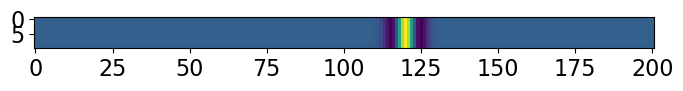

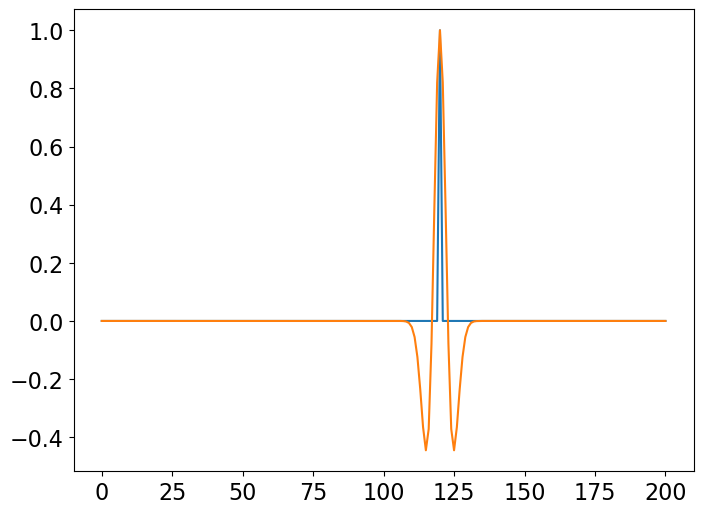

In [18]:
ys = fftconvolve(xs, h[np.newaxis], axes=-1, mode='same')

plt.figure()
plt.imshow(ys)

plt.figure()
plt.plot(xs[2])
plt.plot(ys[2]);

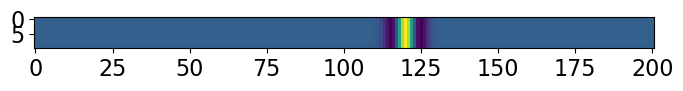

In [19]:
# This is clunky, and so far doesnt work with 1d-input
Xop = Convolve1D((1, nh), h=xs, offset=offset, axis=-1, method='fft')
ys = Xop @ h[np.newaxis]

plt.figure()
plt.imshow(ys);

## Multiple traces for input and multiple filters

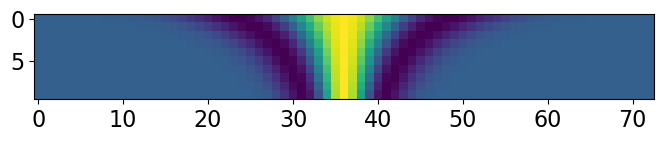

In [20]:
nx, ntraces = 201, 10
xs  = np.zeros((ntraces, nx))
xs[:, 120] = 1

nh = 38
hs = []
for freq in np.linspace(8, 20, ntraces):
    h, _, offset = ricker(np.arange(nh)*0.004, freq)
    hs.append(h)
nh = len(h)
hs = np.array(hs)

plt.figure()
plt.imshow(hs);

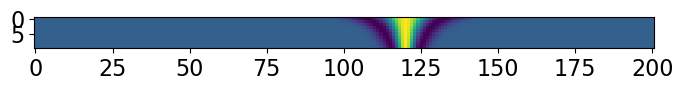

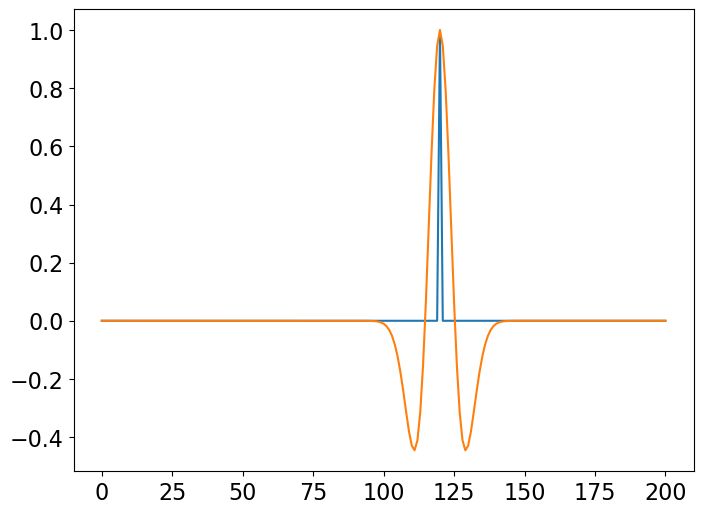

In [21]:
ys = fftconvolve(xs, hs, axes=-1, mode='same')

plt.figure()
plt.imshow(ys)

plt.figure()
plt.plot(xs[2])
plt.plot(ys[2]);

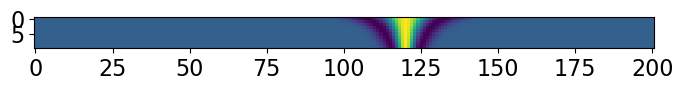

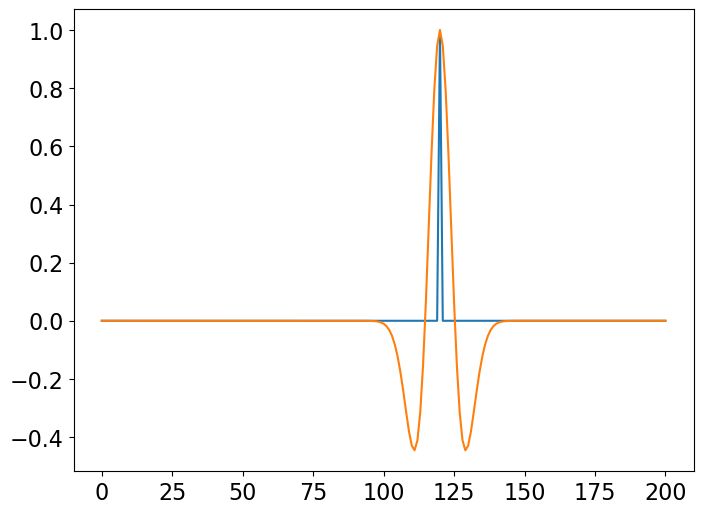

In [22]:
Hop = Convolve1D((ntraces, nx), h=hs, offset=offset, axis=-1, method='fft')

ys = Hop @ xs

plt.figure()
plt.imshow(ys)

plt.figure()
plt.plot(xs[2])
plt.plot(ys[2]);

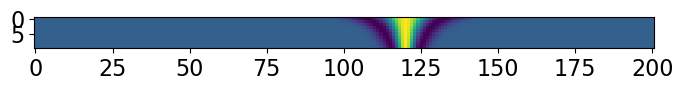

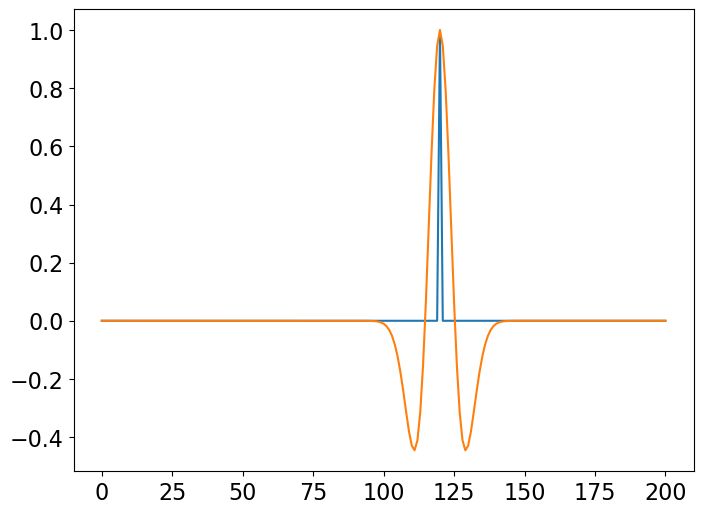

In [23]:
Xop = Convolve1D((ntraces, nh), h=xs, offset=offset, axis=-1, method='fft')

ys = Xop @ hs

plt.figure()
plt.imshow(ys)

plt.figure()
plt.plot(xs[2])
plt.plot(ys[2]);

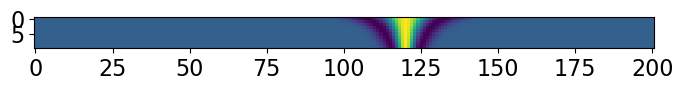

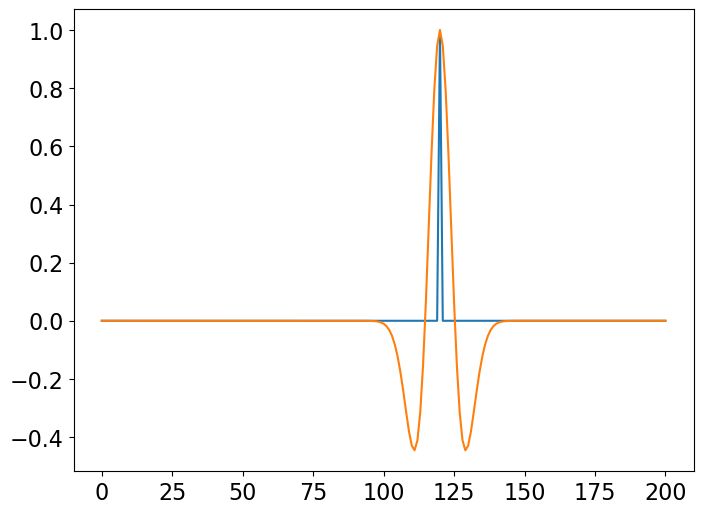

In [24]:
Hop = Convolve1D((nx, ntraces), h=hs.T, offset=offset, axis=0, method='fft')

ys = (Hop @ xs.T).T

plt.figure()
plt.imshow(ys)

plt.figure()
plt.plot(xs[2])
plt.plot(ys[2]);

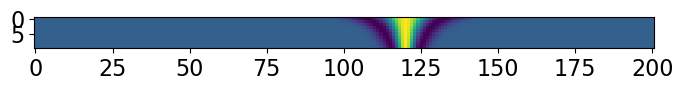

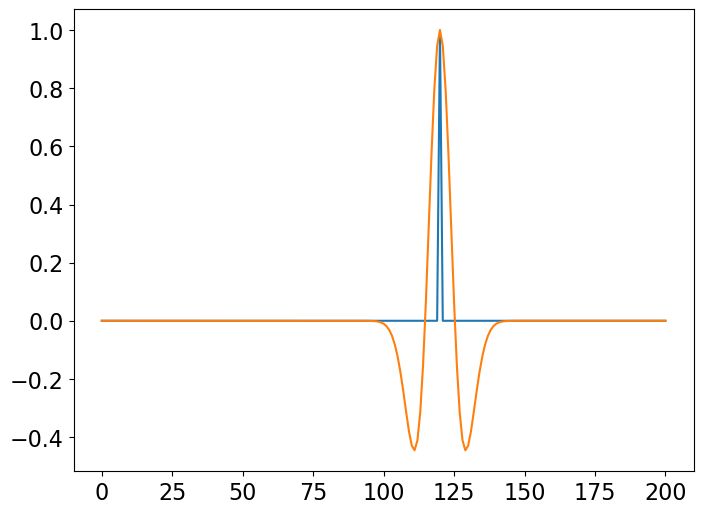

In [25]:
Xop = Convolve1D((nh, ntraces), h=xs.T, offset=offset, axis=0, method='fft')

ys = (Xop @ hs.T).T

plt.figure()
plt.imshow(ys)

plt.figure()
plt.plot(xs[2])
plt.plot(ys[2]);

## Same size for both operator and signal (test correlation between signals)

In [26]:
nx = 501
x  = np.zeros(nx)
x[30] = 0.5
x[50] = -2
x[150] = 1

nh = 38
h, _, offset = ricker(np.arange(nh)*0.004, 8)
nh = len(h)

y = convolve(x, h, 'same')

In [27]:
Yop = Convolve1D(nx, h=y, offset=nx//2)
dottest(Yop, nx, nx, verb=True)

corr = correlate(y,y, 'same')
corrop = Yop.H @ y

convop = Yop @ corr

Dot test passed, v^H(Opu)=102.73026998463847 - u^H(Op^Hv)=102.73026998463848


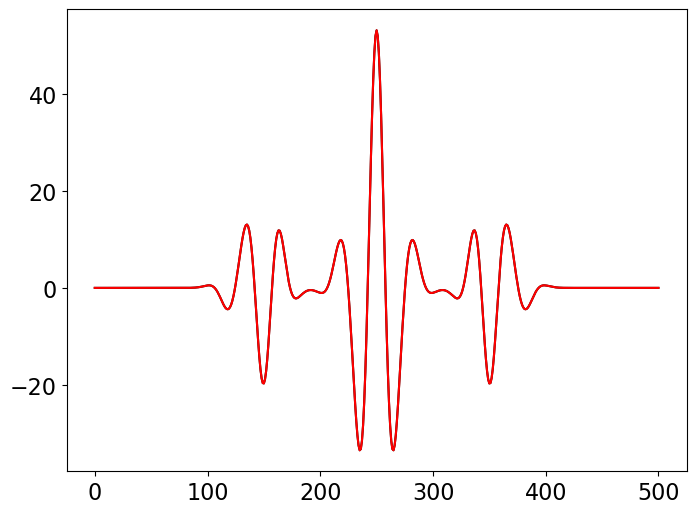

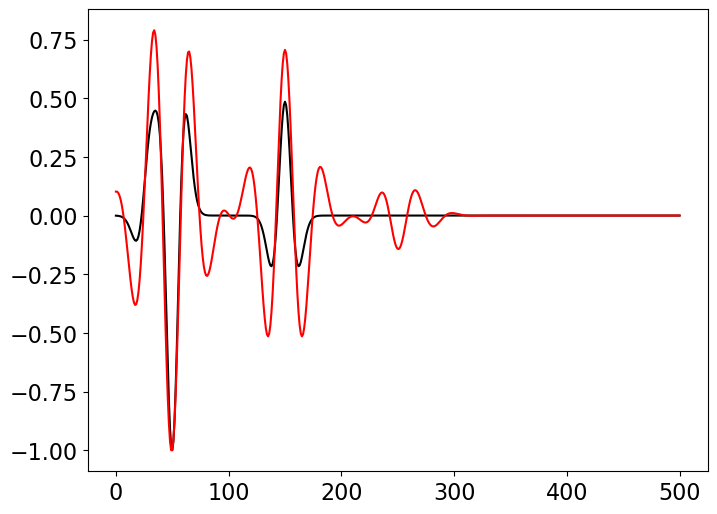

In [28]:
plt.figure()
plt.plot(corr, 'k')
plt.plot(corrop, 'r')

plt.figure()
plt.plot(y/np.max(np.abs(y)), 'k')
plt.plot(convop/np.max(np.abs(convop)), 'r');

And now with 2d data

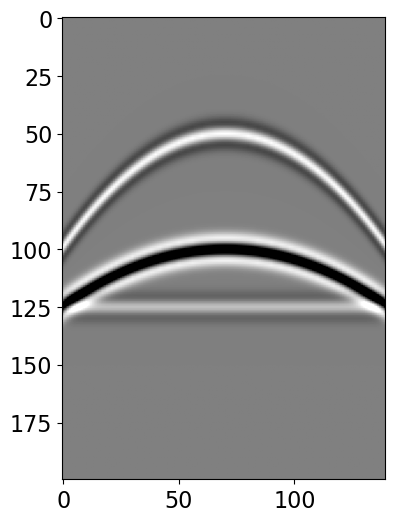

In [29]:
par = {'ox':-140, 'dx':2, 'nx':140,
       'ot':0, 'dt':0.004, 'nt':200,
       'f0': 20}

v = 1500
t0 = [0.2, 0.4, 0.5]
px = [0, 0, 0]
pxx = [1e-5, 5e-6, 1e-20]
amp = [1., -2, 0.5]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)

# Create wavelet
wav = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, data = pylops.utils.seismicevents.parabolic2d(x, t, t0, px,
                                                 pxx, amp, wav)
plt.imshow(data.T, cmap='gray', vmin=-1, vmax=1);

In [30]:
data.shape, par['nx'], par['nt']

((140, 200), 140, 200)

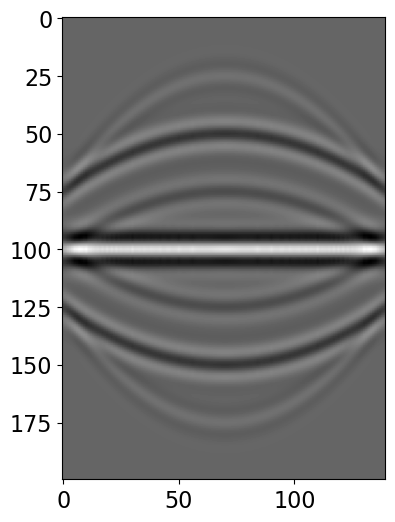

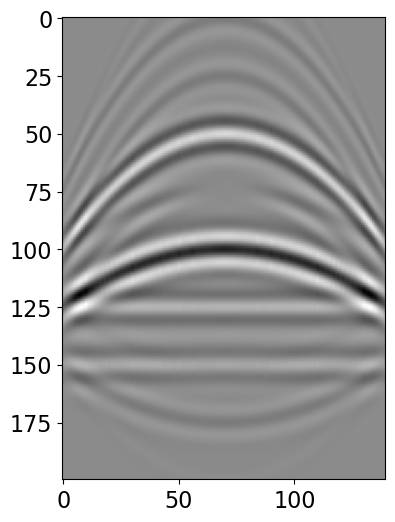

In [31]:
Xop = Convolve1D((par['nx'], par['nt']), h=data, offset=par['nt']//2, axis=-1, method='fft')

corr = Xop.H @ data
conv = Xop @ corr

plt.figure()
plt.imshow(corr.T, cmap='gray');

plt.figure()
plt.imshow(conv.T, cmap='gray');

Finally with multiple 2d data and filters

In [32]:
data1 = np.concatenate([data[np.newaxis], -data[np.newaxis]], axis=0)
data1.shape

(2, 140, 200)

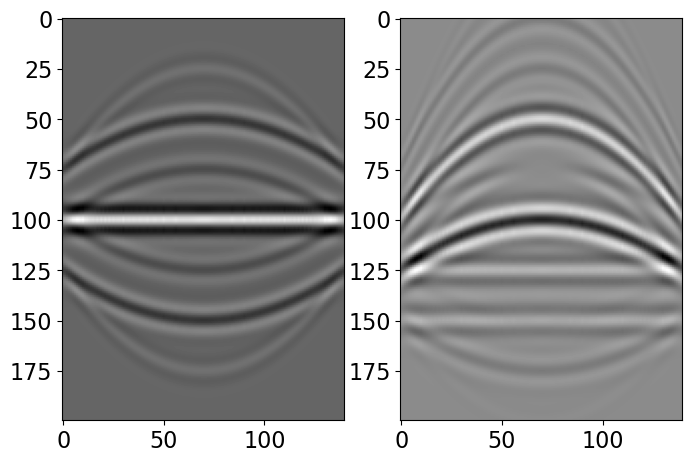

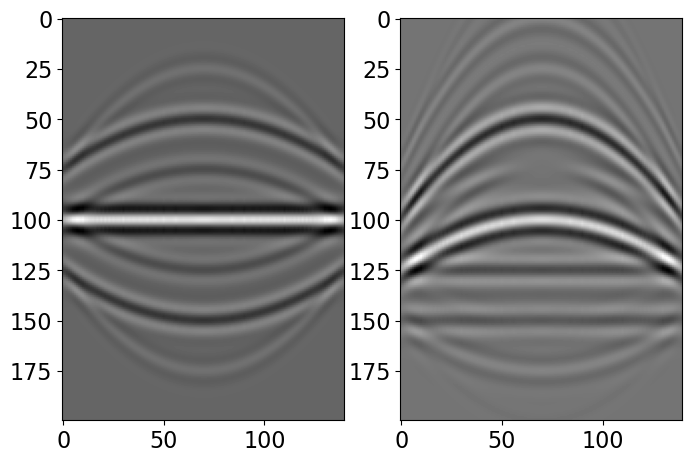

In [33]:
Xop = Convolve1D((2, par['nx'], par['nt']), h=data1, offset=par['nt']//2, axis=-1, method='fft')

corr = Xop.H @ data1
conv = Xop @ corr

fig, axs = plt.subplots(1, 2)
axs[0].imshow(corr[0].T, cmap='gray')
axs[1].imshow(conv[0].T, cmap='gray')

fig, axs = plt.subplots(1, 2)
axs[0].imshow(corr[1].T, cmap='gray')
axs[1].imshow(conv[1].T, cmap='gray');